In [1]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import normalize
from io import BytesIO
from PIL import Image
import seaborn as sns

sns.set_theme(style='darkgrid')

In [2]:
def extract_spectrum_from_url(filename, threshold=25):
    # Load the image from the URL
    response = requests.get(f'https://sdbs.db.aist.go.jp/API/ImageDisplayHandler.ashx?FileName={filename}&SpectralType=rm&FileType=Spectrl&Format=Old')
    image = Image.open(BytesIO(response.content))
    image = image.convert('RGB')  # Ensure the image has 3 channels
    image = np.array(image)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define the fixed high-sensitivity area (bounding rectangle coordinates)
    top_row = 4
    bottom_row = 279
    left_col = 25
    right_col = 737

    # Crop the image to the defined high-sensitivity region
    cropped_gray = gray[top_row:bottom_row, left_col:right_col]

    spectrum_points = []
    height, width = cropped_gray.shape
    for y in range(height):
        for x in range(width):
            if cropped_gray[y, x]< threshold:
                spectrum_points.append([x, y])
    
    spectrum_points = np.array(spectrum_points)

    # Sort by x-coordinate to align with the wavenumber axis
    spectrum_points = spectrum_points[np.argsort(spectrum_points[:, 0])]

    # Extract x (wavenumber) and y (intensity) values
    x_pixels = spectrum_points[:, 0]
    y_pixels = spectrum_points[:, 1]

    # Flip y-axis (image origin is top-left, but plot origin is bottom-left)
    y_pixels = cropped_gray.shape[0] - y_pixels

    # Normalize to map pixels to approximate wavenumber and intensity ranges
    # Assuming x corresponds to 4000-0 cm^-1 and y is intensity 0-100
    x = np.interp(x_pixels, (x_pixels.min(), x_pixels.max()), (4000, 0))
    y = np.interp(y_pixels, (y_pixels.min(), y_pixels.max()), (0, 100))

    return x, y

def lossy_resolution_convert(x, y, n_values, start, end):
    y_2 = []

        # Iterate over the range of x_i values
    for x_i in np.linspace(start, end, n_values):  # Generating 500 points between 4000 and 0
        # Find the index of the closest value in x, but prioritize higher y values
        closest_indices = np.where(np.abs(x - x_i) == np.min(np.abs(x - x_i)))[0]  # All closest indices
        best_index = closest_indices[np.argmax(y[closest_indices])]  # Select index with the highest y value
    
        y_2.append(y[best_index])  # Append the corresponding y value

    return np.array(y_2)

In [3]:
%%time

compound_library = {
    "methanol-d": "RM1733",
    "methylamine": "RM2121",
    "nitromethane": "RM28",
    "dichloromethane": "RM12",
    "benzhydrylamine": "RM3081",
    "formamide": "RM1941",
    "borane-dimethylamine complex": "RM2249",
    "formic acid": "RM560",
    "ethyl alcohol": "RM16",
    "O-methylhydroxylamine hydrochloride": "RM925",
    "acrylonitrile": "RM36"
}

num_points = 500
start, end = 0, 4000
wavenumbers = np.linspace(start, end, num_points)

# Precompute reference spectra for each compound
reference_spectra = {}
for compound, compound_filename in compound_library.items():
    _x, ref_spectrum = extract_spectrum_from_url(compound_filename)
    reference_spectra[compound] = lossy_resolution_convert(_x, ref_spectrum, num_points, start, end)

CPU times: total: 2.25 s
Wall time: 9.92 s


In [4]:

def generate_mixture_spectrum(compounds, concentrations, reference_spectra, noise_level=0.03):
    """
    Generate a synthetic mixture spectrum by linearly combining 
    the reference spectra according to the provided concentrations.
    """
    spectrum = np.zeros_like(wavenumbers)
    
    for compound, concentration in zip(compounds, concentrations):
        spectrum += concentration * reference_spectra[compound]
    # Add some noise
    noise = np.random.normal(0, noise_level, size=spectrum.shape)
    return (spectrum + noise, spectrum)

# Let's create a dataset
n_samples = 10000  # number of training samples
compounds = list(compound_library.keys())
M = len(compounds)

X_data = []
X_data_clean = []
y_data = []

for _ in range(n_samples):
    # Generate random concentrations that sum to 1 (for simplicity).
    # In reality, you may allow them to be any set of random values.
    rand_concs = np.random.rand(M)
    rand_concs /= np.sum(rand_concs)  # normalize so sum=1

    for i in range(0, M):
        if np.random.rand() > 0.7:
            rand_concs[i] = 0
    
    # Get the synthetic mixture spectrum
    mixture_spectrum, mixture_spectrum_clean = generate_mixture_spectrum(compounds, rand_concs, reference_spectra)
    
    X_data.append(mixture_spectrum)
    X_data_clean.append(mixture_spectrum_clean)
    y_data.append(rand_concs)

X_data = np.array(X_data)
X_data_clean = np.array(X_data_clean)
y_data = np.array(y_data)

In [5]:
# Shuffle data
idx = np.random.permutation(n_samples)
X_data = normalize(X_data[idx])
X_data_clean = normalize(X_data_clean[idx])
y_data = normalize(y_data[idx])

# Train/test split
train_size = int(0.8 * n_samples)
X_train, X_test = X_data[:train_size], X_data[train_size:]
X_train_clean, X_test_clean = X_data_clean[:train_size], X_data_clean[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

In [6]:
%%time
# Add early stopping ot prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build a TensorFlow Neural Network
sparcsnet = Sequential([
    Input((num_points,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(M, activation='linear')  # M outputs, one for each compound concentration
])

sparcsnet.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
sparcsnet_history = sparcsnet.fit(
    X_train, y_train,
    epochs=75, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

#sparcsnet.save('sparcsnet.keras')

Epoch 1/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0396 - mae: 0.1622 - val_loss: 0.0051 - val_mae: 0.0531
Epoch 2/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - mae: 0.0404 - val_loss: 8.4538e-04 - val_mae: 0.0225
Epoch 3/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6275e-04 - mae: 0.0212 - val_loss: 6.4554e-04 - val_mae: 0.0196
Epoch 4/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6149e-04 - mae: 0.0182 - val_loss: 5.5482e-04 - val_mae: 0.0181
Epoch 5/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.6497e-04 - mae: 0.0165 - val_loss: 3.9287e-04 - val_mae: 0.0153
Epoch 6/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1163e-04 - mae: 0.0157 - val_loss: 4.3600e-04 - val_mae: 0.0162
Epoch 7/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.8350e-04 - mae: 0.0152 - val_loss: 3.9211e-04 - val_mae: 0.0153
Epoch 8/75
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4442e-04 - mae: 0.0144 - val_loss: 3.6893e-04 - val_mae: 0.0151
Epoc

In [7]:
# Evaluate the Model
mse, mae = sparcsnet.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {mse}, Test MAE: {mae}")

Test MSE: 0.00014967341849114746, Test MAE: 0.009384747594594955


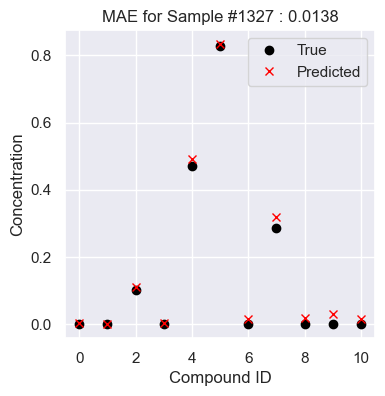

In [8]:
predictions = sparcsnet.predict(X_test, verbose=0)
idx_plot = np.random.randint(0, len(X_test))

sample_mae = mean_absolute_error(predictions[idx_plot], y_test[idx_plot])

x_range = range(0, len(predictions[idx_plot]))
plt.figure(figsize=(4, 4))
plt.plot(x_range, y_test[idx_plot], linestyle='none', marker='o', color='black', label='True')
plt.plot(x_range, predictions[idx_plot], linestyle='none', marker='x', color='red', label='Predicted')
plt.legend(loc='upper right')
plt.title(f"MAE for Sample #{idx_plot} : {sample_mae:0.4f}")
plt.ylabel('Concentration')
plt.xlabel('Compound ID')
plt.show()

In [9]:
%%time
# Add early stopping ot prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build a TensorFlow Neural Network
sparcsnet_reverse = Sequential([
    Input((M,)),  # M inputs, one for each compound concentration
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='gelu'),
    Dense(num_points, activation='linear')
])

sparcsnet_reverse.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
sparcsnet_reverse_history = sparcsnet_reverse.fit(
    y_train, X_train_clean,
    epochs=100, batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

#sparcsnet_reverse.save('sparcsnet_reverse.keras')

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.3064e-04 - mae: 0.0156 - val_loss: 1.0965e-04 - val_mae: 0.0067
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9750e-05 - mae: 0.0060 - val_loss: 3.6714e-05 - val_mae: 0.0038
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0225e-05 - mae: 0.0034 - val_loss: 1.4746e-05 - val_mae: 0.0024
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3242e-05 - mae: 0.0022 - val_loss: 7.6747e-06 - val_mae: 0.0017
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4622e-06 - mae: 0.0017 - val_loss: 5.5793e-06 - val_mae: 0.0015
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7449e-06 - mae: 0.0015 - val_loss: 4.6354e-06 - val_mae: 0.0013
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8531e-06 - mae: 0.0013 - val_loss: 3.8333e-06 - val_mae: 0.0012
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9468e-06 - mae: 0.0012 - val_loss: 3.2865e-06 - 

In [10]:
# Evaluate the Model
mse, mae = sparcsnet_reverse.evaluate(y_test, X_test, verbose=0)
print(f"Test MSE: {mse}, Test MAE: {mae}")

Test MSE: 7.303503934963373e-07, Test MAE: 0.00048089795745909214


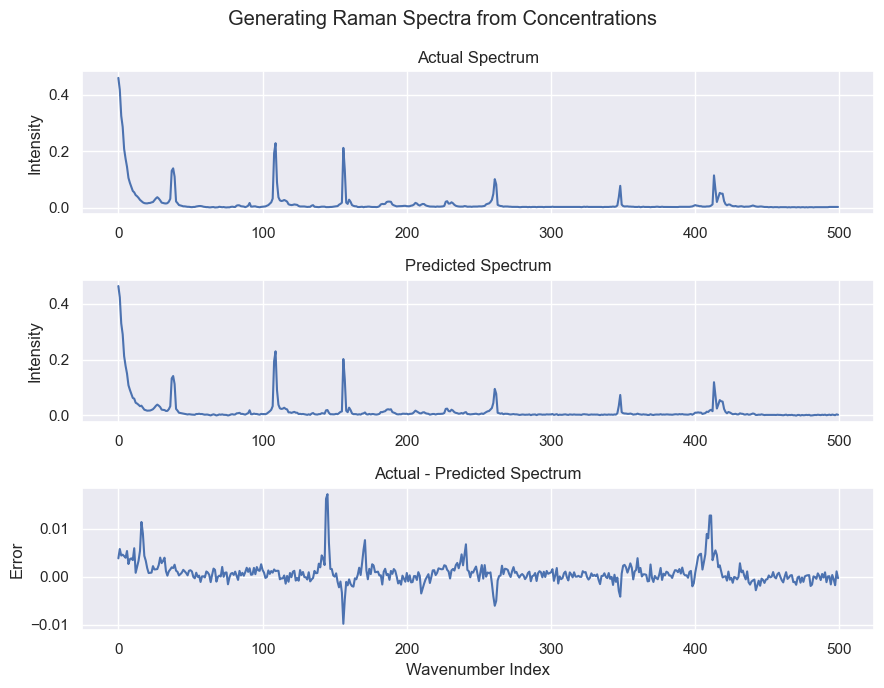

In [27]:
idx_plot = np.random.randint(0, len(y_test) - 1)
predicted_spectrum = sparcsnet_reverse.predict(y_test[idx_plot].reshape((1, M)), verbose=0)[0]

# Create a figure with two subplots arranged vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 7))

# Plot the actual spectrum
ax1.plot(range(num_points), X_test_clean[idx_plot], label='Actual')
ax1.set_title('Actual Spectrum')
ax1.set_ylabel('Intensity')

# Plot the predicted spectrum
ax2.plot(range(num_points), predicted_spectrum, label='Predicted')
ax2.set_title('Predicted Spectrum')
ax2.set_ylabel('Intensity')

# Plot error
ax3.plot(range(num_points), predicted_spectrum - X_test_clean[idx_plot], label='Predicted')
ax3.set_title('Actual - Predicted Spectrum')
ax3.set_xlabel('Wavenumber Index')
ax3.set_ylabel('Error')

fig.suptitle(f"Generating Raman Spectra from Concentrations")

# Adjust the layout to prevent overlap
plt.tight_layout()

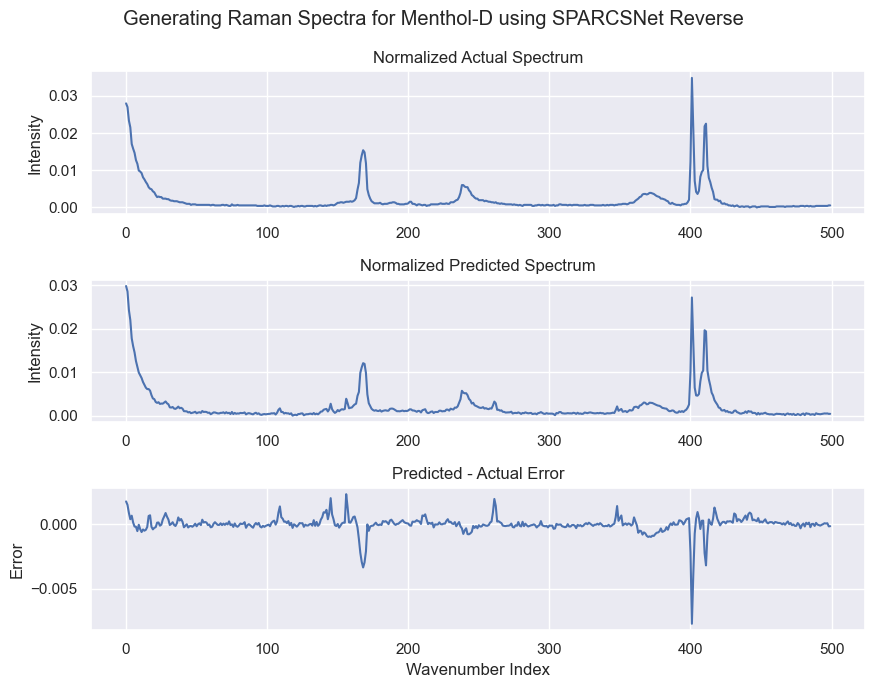

In [32]:
test_conc = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float64)#np.random.rand((M))
test_conc /= sum(test_conc)

noisy_real_spectrum, real_spectrum = generate_mixture_spectrum(compounds, test_conc , reference_spectra)
predicted_spectrum = sparcsnet_reverse.predict(test_conc.reshape(1, M), verbose=0)[0]

predicted_spectrum /= np.sum(predicted_spectrum)
noisy_real_spectrum /= np.sum(noisy_real_spectrum)
real_spectrum /= np.sum(real_spectrum)

# Create a figure with two subplots arranged vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 7))

# Plot the actual spectrum
ax1.plot(range(num_points), real_spectrum, label='Actual')
ax1.set_title('Normalized Actual Spectrum')
ax1.set_ylabel('Intensity')

# Plot the predicted spectrum
ax2.plot(range(num_points), predicted_spectrum, label='Predicted')
ax2.set_title('Normalized Predicted Spectrum')
ax2.set_ylabel('Intensity')

# Plot error
ax3.plot(range(num_points), predicted_spectrum - real_spectrum, label='Predicted')
ax3.set_title('Predicted - Actual Error')
ax3.set_xlabel('Wavenumber Index')
ax3.set_ylabel('Error')

fig.suptitle(f"Generating Raman Spectra for Menthol-D using SPARCSNet Reverse")

# Adjust the layout to prevent overlap
plt.tight_layout()